In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.lib.pandas_util import change_column_name
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '238_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
feature:
    name_bow_pca_dim: 10
    name_bow_word_th1: 5
    name_bow_word_th2: 3
    name_bow_th1_upper: 130
    name_bow_th2_upper: 1000
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])
pd.set_option('display.max_rows', 500)

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test_unknown.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [8]:
df_test.head().T

,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [9]:
df_submission.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


In [10]:
train = df_train.copy()
test = df_test.copy()
train['is_test'] = False
test['is_test'] = True
df_whole = pd.concat([train, test])

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

# Year_of_Release の Nan をみる

In [15]:
df_train.head(85)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,1
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,2
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN,3
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,4
5,LEGO Harry Potter: Years 5-7,X360,NaN,Action,Warner Bros. Interactive Entertainment,51,37,0,9,97,77.0,35.0,7.9,39.0,Traveller's Tales,E10+,5
6,Yakuza 4,PS3,NaN,Action,Sega,15,13,63,5,95,78.0,59.0,8,177.0,Ryu ga Gotoku Studios,M,6
7,LEGO Harry Potter: Years 5-7,PS3,NaN,Action,Warner Bros. Interactive Entertainment,36,41,0,15,91,76.0,27.0,8.3,48.0,Traveller's Tales,E10+,7
8,The Lord of the Rings: War in the North,X360,NaN,Action,Warner Bros. Interactive Entertainment,52,24,0,8,84,61.0,48.0,7.4,113.0,Snowblind Studios,M,8
9,The Lord of the Rings: War in the North,PS3,NaN,Action,Warner Bros. Interactive Entertainment,25,42,1,13,82,63.0,33.0,7,100.0,Snowblind Studios,M,9


In [22]:
df_test.head(185)

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
0,Hitman 2: Silent Assassin,XB,NaN,Action,Eidos Interactive,84.0,23.0,8,19.0,Io Interactive,M,8359
1,Legacy of Kain: Soul Reaver,PS,NaN,Action,Eidos Interactive,91.0,17.0,9,132.0,Crystal Dynamics,T,8360
2,Metal Gear Solid 2: Substance,XB,NaN,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,8361
3,Silent Hill: Homecoming,X360,NaN,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M,8362
4,Silent Hill: Homecoming,PS3,NaN,Action,Konami Digital Entertainment,71.0,41.0,6.9,143.0,Double Helix Games,M,8363
5,Cubix Robots for Everyone: Clash 'n' Bash,GBA,NaN,Action,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,8364
6,Dragon Ball Z: Budokai Tenkaichi 2 (JP sales),Wii,NaN,Action,Atari,NaN,NaN,NaN,NaN,NaN,NaN,8365
7,Shrek the Third,DS,NaN,Action,Activision,70.0,16.0,6.5,4.0,Vicarious Visions,E,8366
8,Nicktoons: Battle for Volcano Island,GC,NaN,Action,THQ,NaN,NaN,7,4.0,Blue Tongue Entertainment,E,8367
9,The Legend of Zelda: The Minish Cap(weekly JP ...,GBA,NaN,Action,Nintendo,NaN,NaN,NaN,NaN,NaN,NaN,8368


In [24]:
df_whole = pd.concat([df_train, df_test], axis=0)
df_whole.shape

(16719, 17)

In [26]:
platform_year_mode = df_whole.groupby('Platform')['Year_of_Release'].agg(lambda x: x.value_counts().index[0])
platform_year_mode_map = dict(platform_year_mode)
platform_year_mode_map

Platform
2600    1981.0
3DO     1995.0
3DS     2011.0
DC      2000.0
DS      2008.0
GB      2000.0
GBA     2002.0
GC      2002.0
GEN     1994.0
GG      1992.0
N64     1999.0
NES     1986.0
NG      1995.0
PC      2011.0
PCFX    1996.0
PS      1998.0
PS2     2002.0
PS3     2011.0
PS4     2016.0
PSP     2006.0
PSV     2015.0
SAT     1995.0
SCD     1994.0
SNES    1995.0
TG16    1995.0
WS      1999.0
Wii     2009.0
WiiU    2013.0
X360    2011.0
XB      2003.0
XOne    2016.0
Name: Year_of_Release, dtype: float64

In [28]:
platform_year_mode_map = dict(platform_year_mode)

In [29]:
df_train.loc[df_train['Year_of_Release'].isna(), 'Year_of_Release'] = df_train.loc[df_train['Year_of_Release'].isna(), 'Platform'].apply(lambda x: platform_year_mode_map[x])

In [30]:
df_train['Year_of_Release'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
8354    False
8355    False
8356    False
8357    False
8358    False
Name: Year_of_Release, Length: 8359, dtype: bool

# User Score など

In [43]:
df_train['is_User_Score_tbd'] = df_train['User_Score'].apply(lambda x: x == 'tbd')
df_train.loc[df_train['User_Score'] == 'tbd', 'User_Score'] = np.nan
df_train['User_Score'] = df_train['User_Score'].astype(np.float32)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df_train_score = df_train[~df_train['is_User_Score_tbd']]
df_train_score['User_Score'] = df_train_score['User_Score'].astype(float)

In [33]:
# rating system がはじまったのはいつから?
columns = [
    'User_Score', 'User_Count', 'Critic_Score', 'Critic_Count',
    'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'
]
df_train_score.groupby('Year_of_Release')[columns].mean()

,User_Score,User_Count,Critic_Score,Critic_Count,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year_of_Release,,,,,,,,,
1980.0,NaN,NaN,NaN,NaN,194.250000,12.250000,0.000000,2.250000,208.750000
1981.0,NaN,NaN,NaN,NaN,68.326087,4.086957,0.000000,0.630435,73.239130
1982.0,NaN,NaN,NaN,NaN,94.565217,5.782609,0.000000,1.043478,101.347826
1983.0,NaN,NaN,NaN,NaN,42.500000,4.928571,57.857143,0.857143,105.928571
1984.0,NaN,NaN,NaN,NaN,361.888889,21.666667,115.111111,7.444444,506.222222
1985.0,NaN,NaN,NaN,NaN,414.125000,58.500000,152.875000,11.375000,636.875000
1986.0,NaN,NaN,NaN,NaN,84.454545,19.909091,80.181818,16.636364,201.000000
1987.0,NaN,NaN,NaN,NaN,62.181818,11.727273,78.727273,1.727273,154.727273
1988.0,2.200000,4572.000000,64.000000,75.000000,209.727273,59.545455,122.090909,8.909091,400.363636


In [34]:
# Platform ごとのスコアは?
columns = [
    'User_Score', 'User_Count', 'Critic_Score', 'Critic_Count',
    'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'
]
df_train_score.groupby('Platform')[columns].mean()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,User_Score,User_Count,Critic_Score,Critic_Count,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Platform,,,,,,,,,
2600,NaN,NaN,NaN,NaN,75.170455,4.556818,0.000000,0.750000,80.568182
3DO,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,2.000000
3DS,7.172642,128.198113,70.700000,37.950000,28.130952,21.317460,33.361111,4.567460,87.424603
DC,8.436364,82.000000,86.818182,17.181818,12.243902,3.560976,16.195122,0.585366,32.634146
DS,7.186054,42.625850,69.088968,27.241993,28.640854,17.750334,19.062750,5.173565,70.662216
GB,NaN,NaN,NaN,NaN,144.166667,60.012821,92.474359,10.269231,306.987179
GBA,7.658824,29.732026,69.815068,18.438356,31.950156,13.451713,12.937695,1.647975,60.052960
GC,7.691824,63.509434,69.857143,25.785714,39.444444,11.838384,9.813131,1.727273,62.919192
GEN,NaN,NaN,NaN,NaN,60.095238,18.380952,12.380952,3.000000,94.000000


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


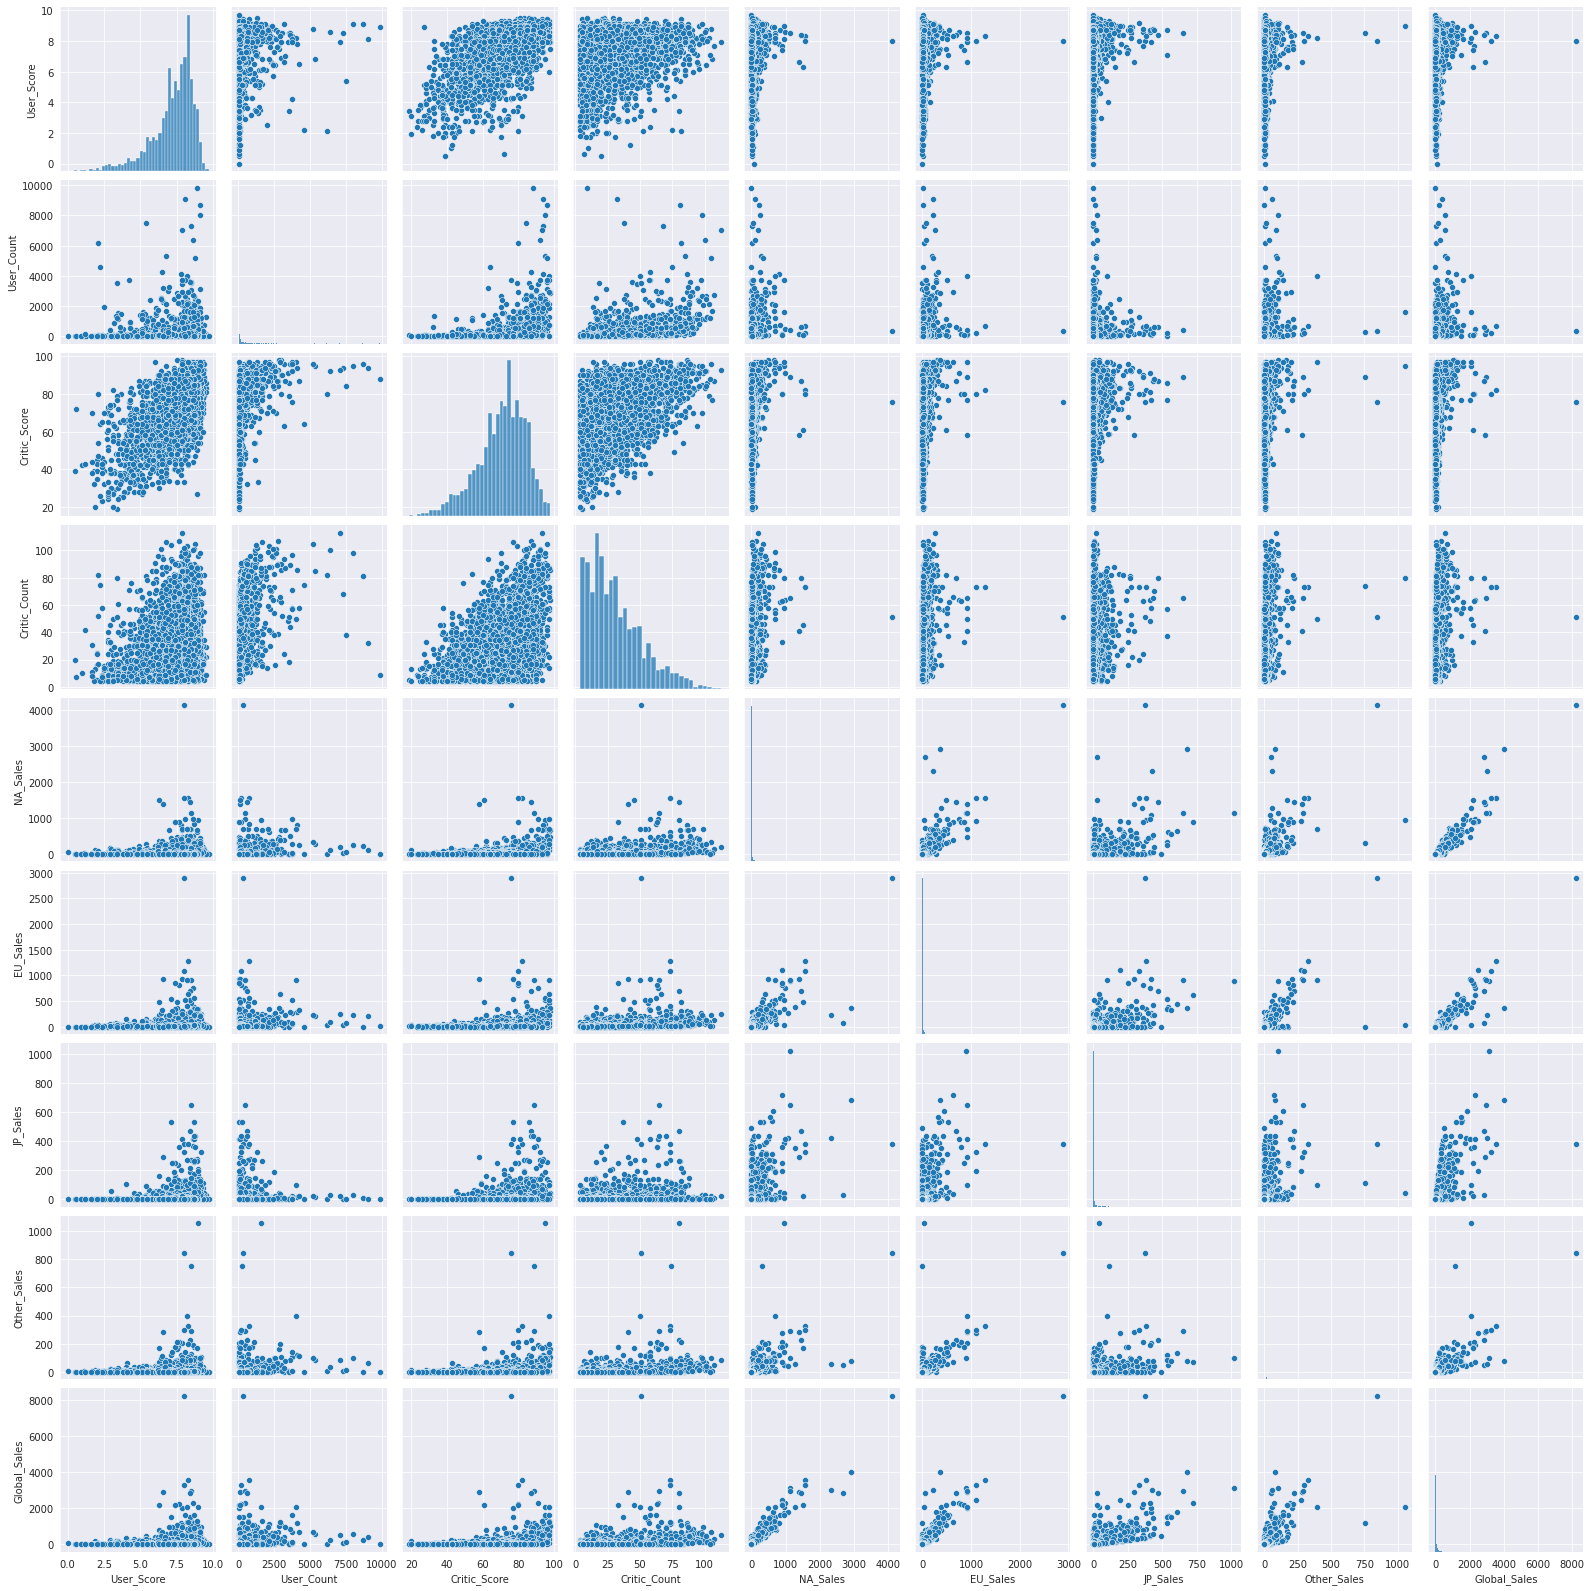

In [35]:
sns.pairplot(df_train[columns])

In [44]:
print((df_train['User_Score'].isna() == df_train['User_Count'].isna()).all())
print((df_train['Critic_Score'].isna() == df_train['Critic_Count'].isna()).all())
print((df_train['User_Score'].isna() == df_train['Critic_Count'].isna()).all())
print((df_train['Critic_Score'].isna() == df_train['User_Count'].isna()).all())

True
True
False
False


In [46]:
np.sum(df_train['User_Score'].isna()), np.sum(df_train['Critic_Score'].isna())

(4660, 4383)

In [45]:
np.sum(df_train.loc[~df_train['User_Score'].isna(), 'Critic_Score'].isna())

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


257

In [47]:
np.sum(df_train.loc[~df_train['Critic_Score'].isna(), 'User_Score'].isna())

534

In [49]:
df_jp = pd.read_csv('../ckpt/248_jp_sales/oof_248_jp_sales.csv')
df_jp

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,JP_Sales
0,0.102296
1,-0.031759
2,-0.081262
3,-0.121036
4,-0.005008
...,...
8354,0.005795
8355,0.046076
8356,1.855743
8357,2.716147
